## Импорт бибилиотек

In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import pathlib
import csv
import scipy

import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import csv

import warnings
warnings.filterwarnings('ignore')

## Загрузка данных с Гугл Диска

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive"

 Bert_эмбеддинги_анализ.ipynb   Итоговая_Аттестационная_Работа_ДПО_Маяцкая_Е.А..pdf
'Colab Notebooks'	        Код
'Copy of МЧС.ipynb'	        Кортежи.ipynb
 documents.gdoc		        Множества.ipynb
 file_1.gdoc		        МЧС.ipynb
 file_2.gdoc		        Обучение_gpt.ipynb
 Untitled0.ipynb	        Отчет_ДПО_Маяцкая_Е.А..pdf
 Алгоритмы.ipynb	        Резюме_Маяцкая_Екатерина_Александровна.pdf
 Данные			        Словари.ipynb
 Задание_AI-ассистент.gdoc      Списки.ipynb


In [5]:
cd /content/drive/My Drive

/content/drive/My Drive


In [6]:
cd 'Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [7]:
ls

 Audio_features            test_fin.csv
 Audo_recognition.ipynb    train_bert.ipynb
 catboost_info/            train_emb.csv
 CodeWars_DS.ipynb         train_fin.csv
 data/                     Untitled
 dataset.csv               Untitled0.ipynb
 fine-Tuning_LLM          'загрузка Llama.ipynb'
 fine-Tuning_LLM.ipynb     Задачи.ipynb
 Linear_Regression.ipynb  'Копия блокнота "BERT+Lstm(end).ipynb"'
 lmsys-chatbot-arena.zip  'Копия блокнота "Untitled94.ipynb"'
 lmsys.ipynb              ' МЧС_изм'
 Log_Regression.ipynb     'МЧС_изм(авт)'
 Numpy.ipynb               обучение_LLM.ipynb
 Pandas.ipynb              Получение_эмбеддингов_и_обучение_трансформера.ipynb
 promt_engenering.ipynb   'Соревнование_LMSYS .ipynb'
 RAG.ipynb                 Хакатон.ipynb
 test_emb.csv


## Загрузка данных

Данные содержат аудио записи человеческой и сгенерированной речи.

**Задача:** определить является ли аудио запись реальным человеческим голосом

In [8]:
#Cписки файлов
human_dir, _, human_files = next(os.walk('./data/training/real'))
spoof_dir, _, spoof_files = next(os.walk('./data/training/fake'))
print(f"Human files: {len(human_files)}\nSpoof files: {len(spoof_files)}")

Human files: 1070
Spoof files: 2172


Функция расчета признаков аудио сигнала

- Средние значения и стандартные отклонения Мел-кепстральных коэффициентов ( по 20 значений);

- Среднее значение, стандартное отклонение и skew (наклон) Спектрального центроида

- Среднее значение и стандартное отклонение Спектрального спада;

In [2]:
def extract_features(directory, file):
    name = f'{directory}/{file}'
    y, sr = librosa.load(name, mono=True, duration=5)

    features = []
    features.append(file) # filename
    features.extend([np.mean(e) for e in librosa.feature.mfcc(y=y, sr=sr,
                                                              n_mfcc=20)])  # mfcc_mean<0..20>
    features.extend([np.std(e) for e in librosa.feature.mfcc(y=y, sr=sr,
                                                             n_mfcc=20)])   # mfcc_std
    features.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T,
                            axis = 0)[0])     # cent_mean
    features.append(np.std(librosa.feature.spectral_centroid(y=y,sr=sr).T,
                           axis = 0)[0])       # cent_std
    features.append(scipy.stats.skew(librosa.feature.spectral_centroid(y=y,sr=sr).T,
                                     axis = 0)[0])    # cent_skew
    features.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T,
                            axis = 0)[0])      # rolloff_mean
    features.append(np.std(librosa.feature.spectral_rolloff(y=y, sr=sr).T,
                           axis = 0)[0])       # rolloff_std


    features.append(directory.split('/')[-1])
    return features

In [9]:
buffer = []
buffer_size = 5000
buffer_counter = 0

# Создание заголовка для файла CSV.
header = ['filename']
header.extend([f'mfcc_mean{i}' for i in range(1, 21)])
header.extend([f'mfcc_std{i}' for i in range(1, 21)])
header.extend(['cent_mean', 'cent_std', 'cent_skew', 'rolloff_mean', 'rolloff_std',
               'label'])

with open('dataset.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(header)
    for directory, files in [(human_dir, human_files), (spoof_dir, spoof_files)]:
        for file in files:
            features = extract_features(directory, file)
            if buffer_counter + 1 == buffer_size:
                buffer.append(features)
                writer.writerows(buffer)
                print(f"- [{directory.split('/')[-1]}] Write {len(buffer)} rows")
                buffer = []
                buffer_counter = 0
            else:
                buffer.append(features)
                buffer_counter += 1
        if buffer:
            writer.writerows(buffer)
            print(f"- [{directory.split('/')[-1]}] Write {len(buffer)} rows")
        print(f"- [{directory.split('/')[-1]}] Writing complete")
        buffer = []
        buffer_counter = 0

- [real] Write 1070 rows
- [real] Writing complete
- [fake] Write 2172 rows
- [fake] Writing complete


In [10]:
df = pd.read_csv('./dataset.csv')

In [11]:
df = df.sample(frac=1).reset_index()

In [12]:
df.head()

,index,filename,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,...,mfcc_std17,mfcc_std18,mfcc_std19,mfcc_std20,cent_mean,cent_std,cent_skew,rolloff_mean,rolloff_std,label
0,814,file29859.wav_16k.wav_norm.wav_mono.wav_silenc...,-174.81064,123.43083,-69.558420,27.034569,-20.427351,-1.620835,-6.929156,-19.711384,...,6.435041,6.940960,6.405052,5.127906,1758.251147,562.764427,1.610835,3310.692335,846.041948,real
1,459,file30184.wav_16k.wav_norm.wav_mono.wav_silenc...,-231.52373,105.93152,-19.329802,19.742140,-43.234085,8.274216,-27.411758,-12.147648,...,9.231453,7.437624,6.883217,6.687924,2543.801584,2013.862851,1.037732,3881.767689,2383.182141,real
2,2206,file1125.mp3.wav_16k.wav_norm.wav_mono.wav_sil...,-172.95280,136.23814,-57.396710,36.368298,-31.149292,5.385503,-20.707506,-6.337903,...,8.700924,7.558128,9.876263,8.929201,1590.198710,665.778143,1.461035,2934.626399,1403.795418,fake
3,1272,file2680.mp3.wav_16k.wav_norm.wav_mono.wav_sil...,-170.67126,164.73079,-40.506172,58.945255,8.136011,1.720430,0.819190,8.259555,...,8.165613,9.328321,7.841833,8.690800,1334.187791,786.050640,2.172005,2679.889949,1380.975103,fake
4,2512,file1516.mp3.wav_16k.wav_norm.wav_mono.wav_sil...,-197.92003,140.62096,-59.136734,43.080097,-18.316460,8.591222,-6.429421,-22.406498,...,8.210041,5.798946,5.635915,8.110507,1429.050947,599.287083,1.694617,2698.772912,1067.745403,fake


**В таблице data мы видим:**

- столбец ‘filename’, где указан номер и название файла (Аудиофайлы перемешаны);

- столбцы ‘mfcc_mean{i}’ и ‘mfcc_std{i}’ - средние значения и стандартные отклонения (по 20 значений) из Мел-кепстральных коэффициентов;

- столбцы 'cent_mean', 'cent_std', 'cent_skew' - среднее значение, стандартное отклонение и skew (наклон) из Спектрального центроида;

- столбцы 'rolloff_mean', 'rolloff_std' - среднее значение и стандартное отклонение из Спектрального спада ;

- столбец ‘label’ метка.

## Посмотрим на эти признаки

Мел-кепстральные коэффициенты

In [17]:
y_real, sr_real = librosa.load('./data/training/real/file30106.wav_16k.wav_norm.wav_mono.wav_silence.wav', mono=True, duration=5)

In [15]:
y_fake, sr_fake = librosa.load('./data/training/fake/file1254.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav', mono=True, duration=5)

Text(0.5, 1.0, 'MFCC_fake')

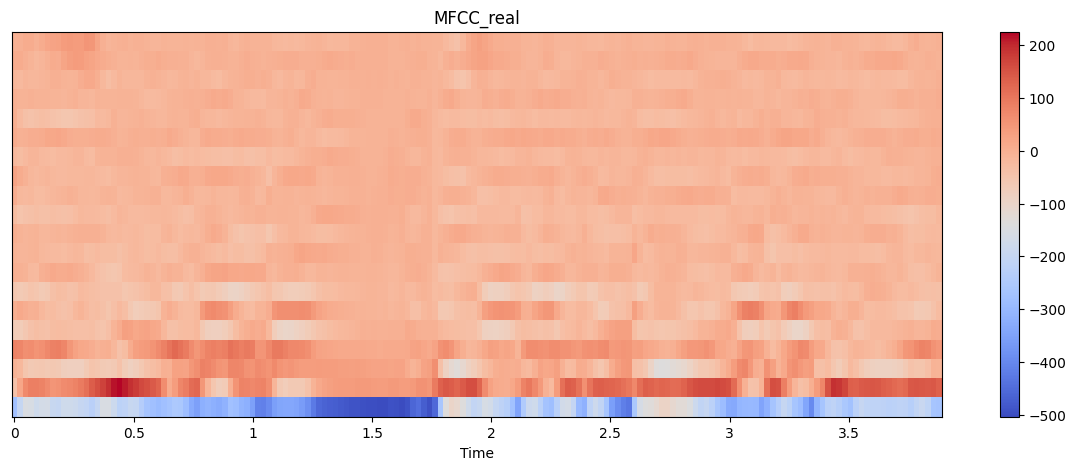

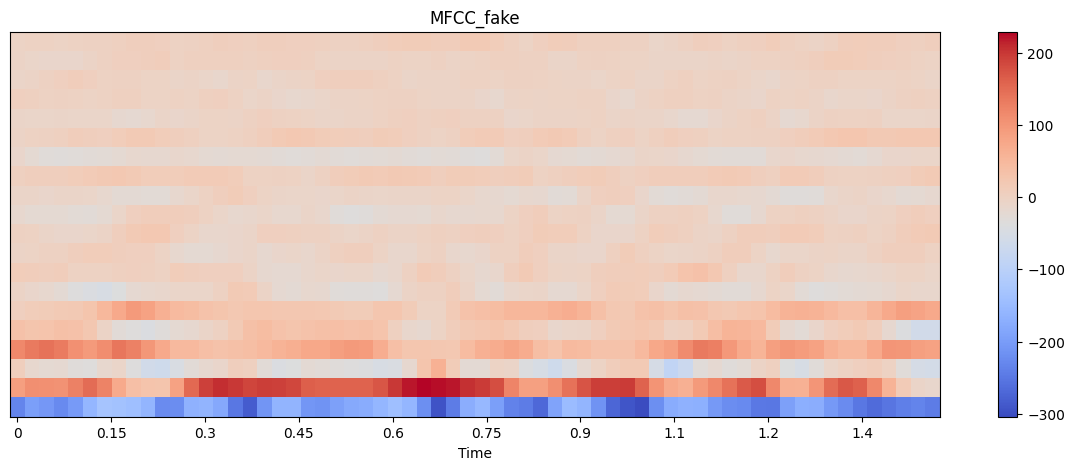

In [18]:
# Calculate MFCCs
mfccs_1 = librosa.feature.mfcc(y=y_real, sr=sr_real, n_mfcc=20)
mfccs_2 = librosa.feature.mfcc(y=y_fake, sr=sr_fake, n_mfcc=20)


plt.figure(figsize=(15, 5))
librosa.display.specshow(mfccs_1, x_axis='time')
plt.colorbar()
plt.title('MFCC_real')

plt.figure(figsize=(15, 5))
librosa.display.specshow(mfccs_2, x_axis='time')
plt.colorbar()
plt.title('MFCC_fake')

Средние значения и стандартные отклонения Мел-кепстральных коэффициентов в виде двухмерной таблицы (Dataframes), состоящей из столбцов и строки и в виде графика.

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,...,mfccs_std_10,mfccs_std_11,mfccs_std_12,mfccs_std_13,mfccs_std_14,mfccs_std_15,mfccs_std_16,mfccs_std_17,mfccs_std_18,mfccs_std_19
0,-276.661499,82.424698,-13.541506,36.025066,-29.828892,-4.987404,-41.038216,-9.669691,-16.934845,-13.237288,...,12.92569,9.857436,13.087965,9.829038,9.686344,12.313072,7.617592,9.063581,10.277133,13.601554


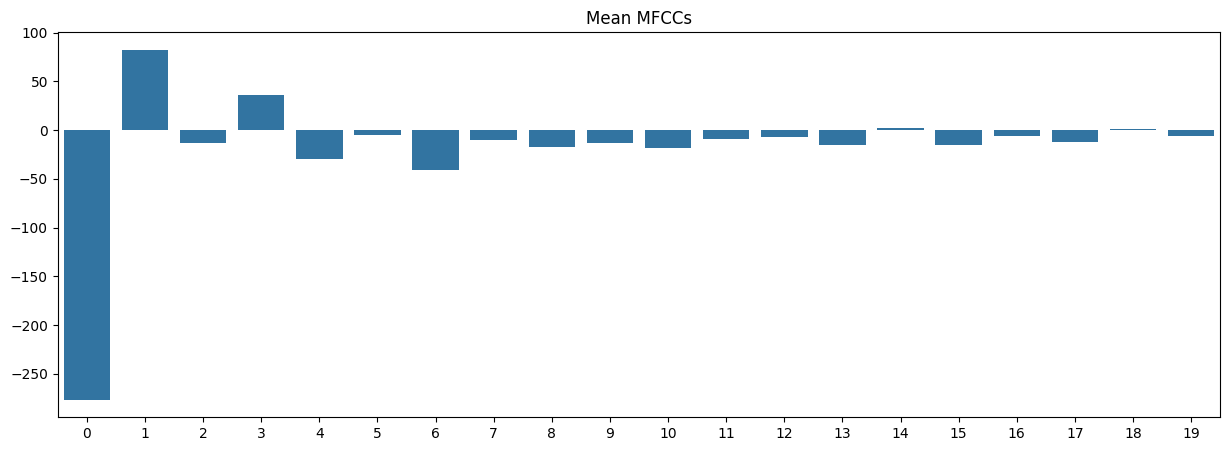

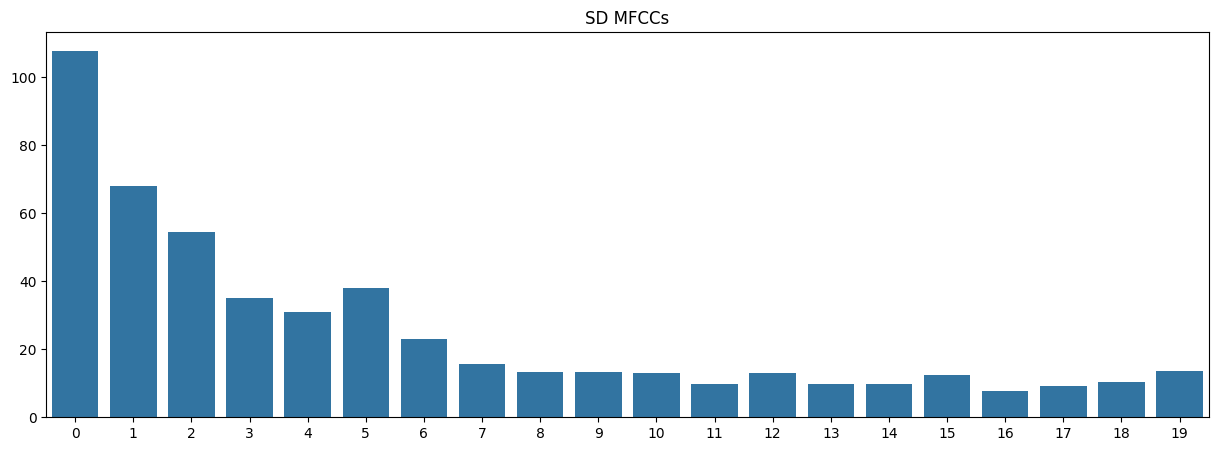

In [19]:
# Feature Generation
# MFCCs
mfccs = librosa.feature.mfcc(y=y_real, sr=sr_real, n_mfcc=20)
mfccs_mean=np.mean(mfccs,axis=1)
mfccs_std=np.std(mfccs,axis=1)

coeffs=np.arange(0,20)
plt.figure(figsize=(15,5))
plt.title('Mean MFCCs')
sns.barplot(x=coeffs,y=mfccs_mean)

plt.figure(figsize=(15,5))
plt.title('SD MFCCs')
sns.barplot(x=coeffs,y=mfccs_std)
# Generate the chroma Dataframe
mfccs_df=pd.DataFrame()
for i in range(0,20):
    mfccs_df['mfccs_mean_'+str(i)]=mfccs_mean[i]
for i in range(0,20):
    mfccs_df['mfccs_std_'+str(i)]=mfccs_mean[i]
mfccs_df.loc[0]=np.concatenate((mfccs_mean,mfccs_std),axis=0)
mfccs_df

Спектральный центроид - Spectral Centroid

Спектральный центроид относится к спектральным (частотным) признакам. =

Спектральный центроид указывает, на какой частоте сосредоточена энергия спектра ( энергия напряжения) или, другими словами, указывает, где расположен “центр масс” для звука.

Среднее значение, стандартное отклонение и skew (наклон) Спектрального центроида

In [20]:
cent = librosa.feature.spectral_centroid(y=y_real, sr=sr_real)
cent_mean=np.mean(cent)
cent_std=np.std(cent)
cent_skew=scipy.stats.skew(cent,axis=1)[0]
print('Mean: '+str(cent_mean))
print('SD: '+str(cent_std))
print('Skewness: '+str(cent_skew))

Mean: 2488.5581532566525
SD: 1698.6104951185384
Skewness: 0.9766937304309661


In [21]:
cent = librosa.feature.spectral_centroid(y=y_fake, sr=sr_fake)
cent_mean=np.mean(cent)
cent_std=np.std(cent)
cent_skew=scipy.stats.skew(cent,axis=1)[0]
print('Mean: '+str(cent_mean))
print('SD: '+str(cent_std))
print('Skewness: '+str(cent_skew))

Mean: 1540.4792101254927
SD: 1192.4161486825149
Skewness: 1.2116111087523327


Спектральный спад - Spectral Rolloff

Спектральный спад относится к спектральным (частотным) признакам. Это мера формы сигнала, представляющая собой частоту, в которой высокие частоты снижаются до 0. Чтобы получить ее, нужно рассчитать долю элементов в спектре мощности, где 85% ее мощности находится на более низких частотах.

Среднее значение и стандартное отклонение Спектрального спада

In [22]:
rolloff = librosa.feature.spectral_rolloff(y=y_real, sr=sr_real)
rolloff_mean=np.mean(rolloff)
rolloff_std=np.std(rolloff)
rolloff_skew=scipy.stats.skew(rolloff,axis=1)[0]
print('Mean: '+str(rolloff_mean))
print('SD: '+str(rolloff_std))
print('Skewness: '+str(rolloff_skew))

Mean: 4077.850341796875
SD: 1992.27426275485
Skewness: 0.175704011850206


In [23]:
rolloff = librosa.feature.spectral_rolloff(y=y_fake, sr=sr_fake)
rolloff_mean=np.mean(rolloff)
rolloff_std=np.std(rolloff)
rolloff_skew=scipy.stats.skew(rolloff,axis=1)[0]
print('Mean: '+str(rolloff_mean))
print('SD: '+str(rolloff_std))
print('Skewness: '+str(rolloff_skew))

Mean: 2930.870819091797
SD: 1865.7141905827839
Skewness: 0.4991568310777706


Видно, что данные характеристики отличаются в заависимости от типа сигнала (реальный/сгенерированный)

## Обучение модели классификатора

In [24]:
y = df['label'].values

In [25]:
X = df.drop(['label', 'filename','index'], axis=1)

In [26]:
X.head()

,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,mfcc_mean10,...,mfcc_std16,mfcc_std17,mfcc_std18,mfcc_std19,mfcc_std20,cent_mean,cent_std,cent_skew,rolloff_mean,rolloff_std
0,-174.81064,123.43083,-69.558420,27.034569,-20.427351,-1.620835,-6.929156,-19.711384,-1.412925,1.976937,...,6.940263,6.435041,6.940960,6.405052,5.127906,1758.251147,562.764427,1.610835,3310.692335,846.041948
1,-231.52373,105.93152,-19.329802,19.742140,-43.234085,8.274216,-27.411758,-12.147648,-25.614860,4.193884,...,10.045878,9.231453,7.437624,6.883217,6.687924,2543.801584,2013.862851,1.037732,3881.767689,2383.182141
2,-172.95280,136.23814,-57.396710,36.368298,-31.149292,5.385503,-20.707506,-6.337903,-10.594726,-8.513454,...,7.893628,8.700924,7.558128,9.876263,8.929201,1590.198710,665.778143,1.461035,2934.626399,1403.795418
3,-170.67126,164.73079,-40.506172,58.945255,8.136011,1.720430,0.819190,8.259555,-7.957178,8.875194,...,11.490403,8.165613,9.328321,7.841833,8.690800,1334.187791,786.050640,2.172005,2679.889949,1380.975103
4,-197.92003,140.62096,-59.136734,43.080097,-18.316460,8.591222,-6.429421,-22.406498,-9.399740,-9.699448,...,6.449655,8.210041,5.798946,5.635915,8.110507,1429.050947,599.287083,1.694617,2698.772912,1067.745403


стандартизация

In [27]:
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)

In [28]:
from sklearn.model_selection import train_test_split
# Разделение набора данных на тренировочные и тестовые наборы (train/test split)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,
                                                            random_state=41)

# размер тренировочных и тестовых наборов (количество строк, колонок):
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

from sklearn import svm
clf = svm.SVC(kernel='rbf')   #  функция ядра - RBF (радиальная базисная функция)
clf.fit(X_train, y_train)     # Обучение модели на тренировочном наборе
yhat = clf.predict(X_test)    # для прогнозирования новых значений:

Train set: (2593, 45) (2593,)
Test set: (649, 45) (649,)


In [29]:
print("Prediction:", yhat[0:5])
print("Real Value:", y_test[0:5])

Prediction: ['fake' 'real' 'real' 'fake' 'fake']
Real Value: ['fake' 'real' 'real' 'fake' 'fake']


In [30]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(X_train)))
print("Test set Accuracy: ",metrics.accuracy_score(y_test, yhat) )

Train set Accuracy:  0.9949865021210953
Test set Accuracy:  0.9830508474576272


In [31]:
from sklearn.metrics import classification_report,confusion_matrix

print('REPORT :\n')
print(classification_report(y_test,yhat))

REPORT :

              precision    recall  f1-score   support

        fake       0.98      0.99      0.99       452
        real       0.98      0.96      0.97       197

    accuracy                           0.98       649
   macro avg       0.98      0.98      0.98       649
weighted avg       0.98      0.98      0.98       649

